In [13]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19

In [2]:
color = 'rgb' #'grayscale' o 'rgb'

escala = 150

In [3]:
def cargar_datos(path1, path2, escala = escala, color = color):
    
    EMD = os.listdir(path1)
    NO_EMD = os.listdir(path2)
    
    data = []
    labels = []

    for i in EMD:   
        image=tf.keras.preprocessing.image.load_img(path1+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(1)
    for i in NO_EMD:   
        image=tf.keras.preprocessing.image.load_img(path2+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(0)
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

### TRAIN: OCT + iPhone

### TEST: Samsung

In [4]:
dataset_iphone = cargar_datos('Datos EMD/iPhone/EMD', 'Datos EMD/iPhone/NO EMD')

In [5]:
dataset_samsung = cargar_datos('Datos EMD/Samsung/EMD', 'Datos EMD/Samsung/NO EMD')

In [6]:
dataset = cargar_datos('Datos EMD/OCT/EMD', 'Datos EMD/OCT/NO EMD')

In [7]:
train_ds = np.concatenate((dataset[0],dataset_iphone[0]))

train_labels = np.concatenate((dataset[1],dataset_iphone[1]))

In [8]:
test_ds = dataset_samsung[0]

test_labels = dataset_samsung[1]

In [9]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [14]:
## Loading VGG16 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

80134624/80134624 [==============================] - 23s 0us/step


In [15]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
6/6 [==============================] - 10s 2s/step - loss: 6.3171 - accuracy: 0.5604 - val_loss: 5.5253 - val_accuracy: 0.1522
Epoch 2/200
6/6 [==============================] - 9s 2s/step - loss: 1.9335 - accuracy: 0.7582 - val_loss: 6.0696 - val_accuracy: 0.1522
Epoch 3/200
6/6 [==============================] - 11s 2s/step - loss: 1.2989 - accuracy: 0.7802 - val_loss: 0.5972 - val_accuracy: 0.7826
Epoch 4/200
6/6 [==============================] - 11s 2s/step - loss: 0.3964 - accuracy: 0.8736 - val_loss: 2.9196 - val_accuracy: 0.3696
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 0.4271 - accuracy: 0.8407 - val_loss: 0.8068 - val_accuracy: 0.7391
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.3217 - accuracy: 0.8901 - val_loss: 4.4118 - val_accuracy: 0.3913
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.1246 - accuracy: 0.9505 - val_loss: 2.1456 - val_accuracy: 0.5000
Epoch 8/200
6/6 [===========

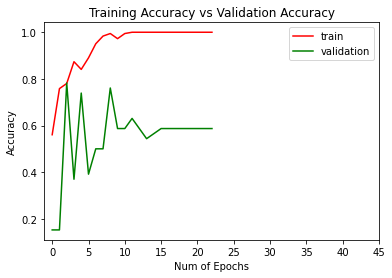

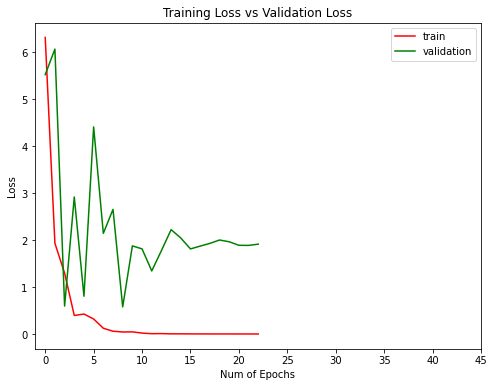

In [17]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

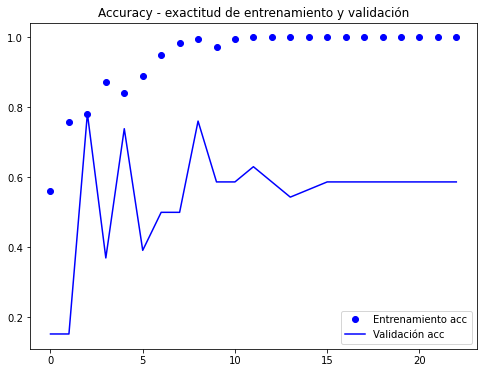

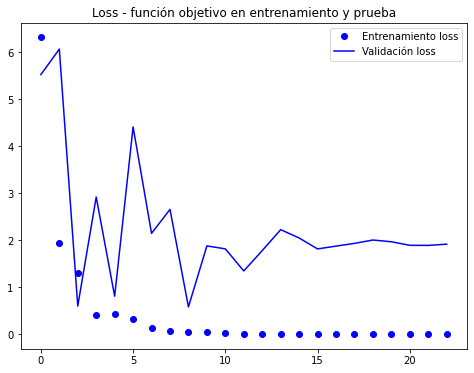

In [18]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 4s 880ms/step


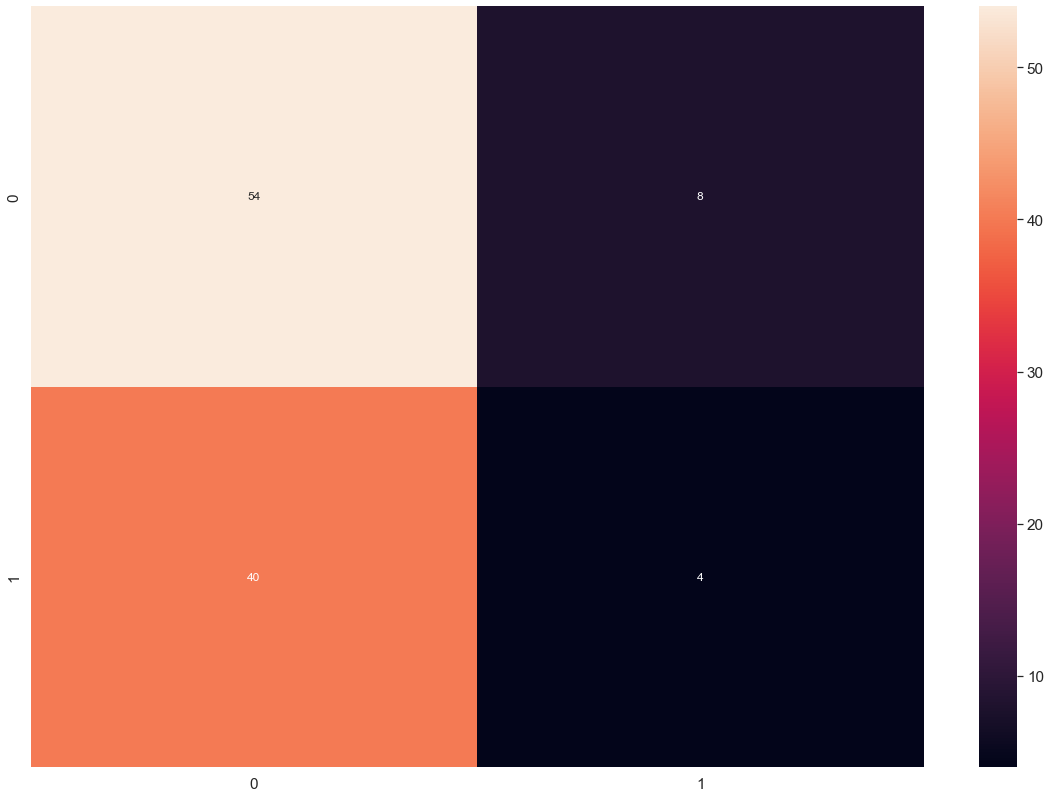

In [19]:
vgg19 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg19_predicted = np.argmax(vgg19, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels, axis=1), vgg19_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

### TRAIN: OCT + Samsung

### TEST: iPhone

In [20]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

In [21]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [22]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [23]:
## Loading VGG16 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [24]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/200
6/6 [==============================] - 10s 2s/step - loss: 5.0006 - accuracy: 0.6215 - val_loss: 20.2296 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 9s 2s/step - loss: 2.2261 - accuracy: 0.7006 - val_loss: 1.3788 - val_accuracy: 0.6889
Epoch 3/200
6/6 [==============================] - 11s 2s/step - loss: 1.0283 - accuracy: 0.7966 - val_loss: 6.4517 - val_accuracy: 0.0000e+00
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.6713 - accuracy: 0.7910 - val_loss: 2.0753 - val_accuracy: 0.3556
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 0.4255 - accuracy: 0.8249 - val_loss: 1.4932 - val_accuracy: 0.2889
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.2680 - accuracy: 0.8870 - val_loss: 1.1661 - val_accuracy: 0.3778
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.2616 - accuracy: 0.8927 - val_loss: 2.7150 - val_accuracy: 0.0889
Epoch 8/200
6/6 [==

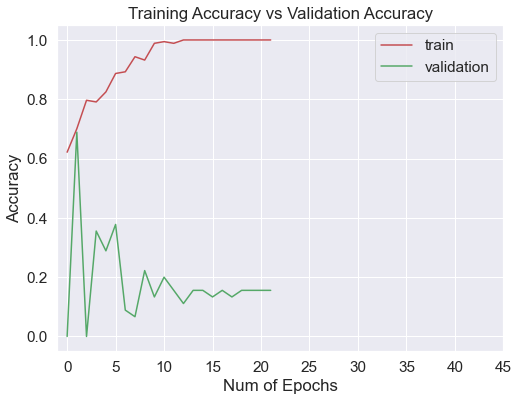

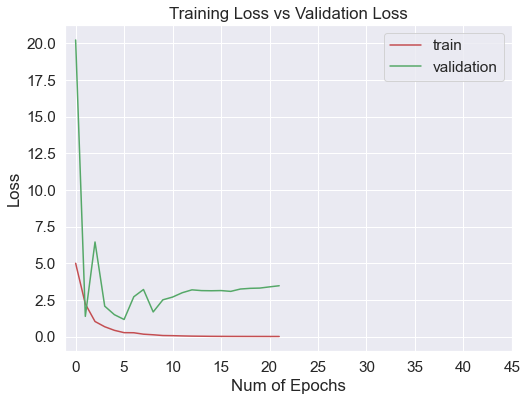

In [26]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

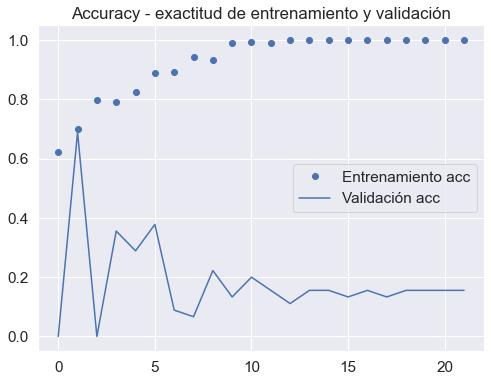

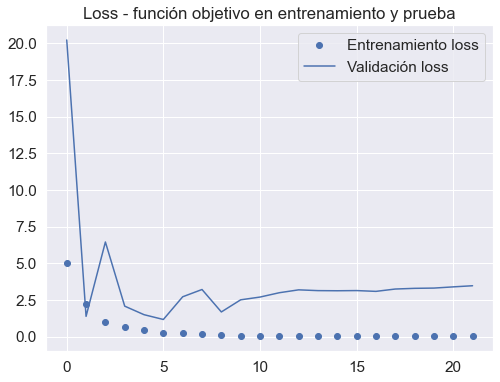

In [27]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 4s 969ms/step


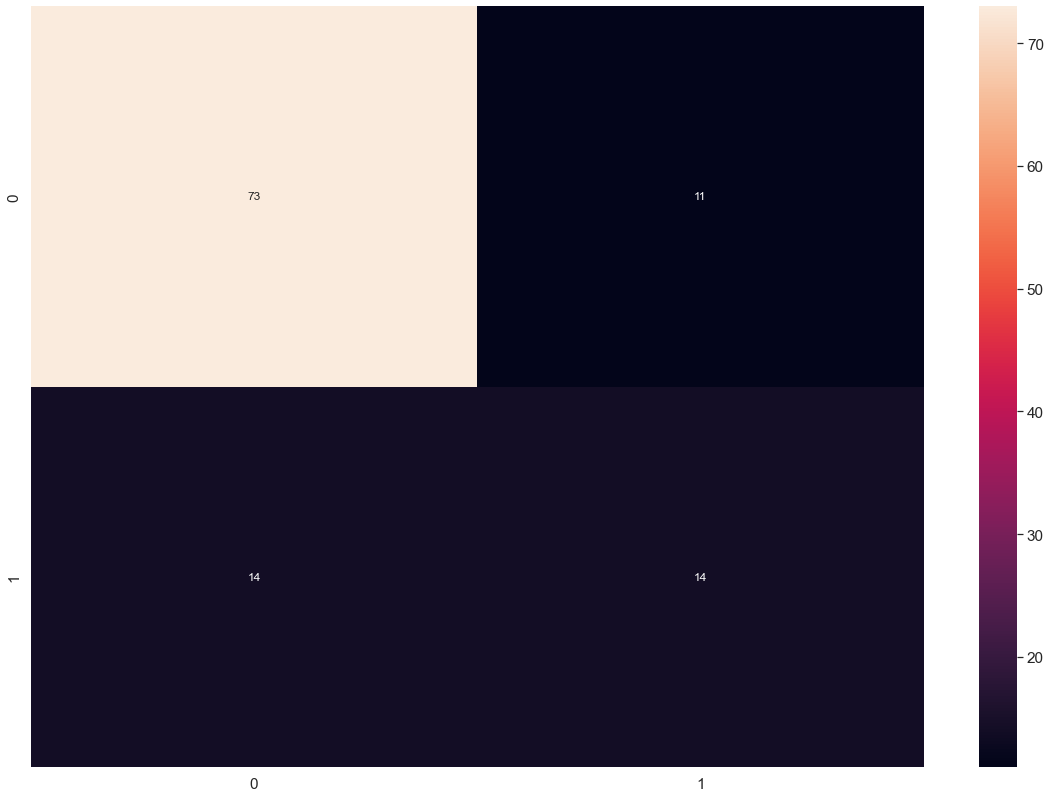

In [28]:
vgg19 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg19_predicted = np.argmax(vgg19, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels, axis=1), vgg19_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 